In [14]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.16.1
KerasNLP version: 0.12.1


# Disaster Tweets NLP Challenge

## Problem Description:

<span style="font-size:1.1em;">  The goal is to be able to classify wether or not a particular tweet is referring to an actual disaster in progress vs just language that sounds like that.</span>


<span style="font-size:1.1em;"> Lets first load the data and explore it </span>


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%cd /content/drive/My Drive/nlp-getting-started/

/content/drive/My Drive/nlp-getting-started


In [17]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [18]:

df_train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<span style="font-size:1.1em;"> We see that we have 7613 training examples and 3263 test examples.
The training data containes an id column which provides a numerical id number for each twet text. a text column with the actual test and a target column which has the training label 1 means the tweet is actually referring to a real disaster, 0 means its not.
There are also keywod and location columns which seems to not contain any useful data.
The test dataframe has the same structue except it doesnt have the training label ("target")column.</span>

<span style="font-size:1.1em;"> We also see that all the tweets are in english</span>

<span style="font-size:1.1em;"> Lets looks at some statistics on teh length of the tweets</span>


In [20]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))


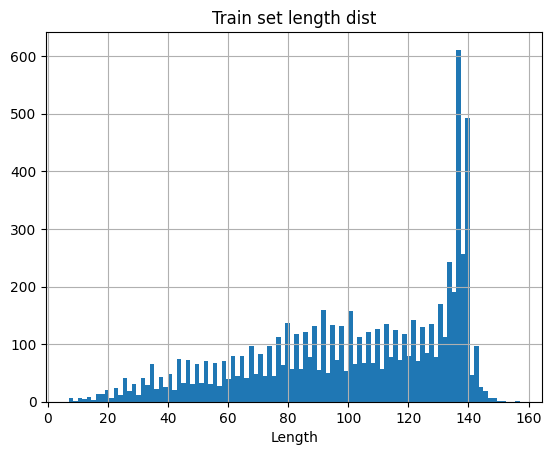

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


In [21]:
df_train["length"].hist(bins=100)
plt.xlabel("Length")
plt.title("Train set length dist")
plt.show()
print("Train Length Stat")
print(df_train["length"].describe())

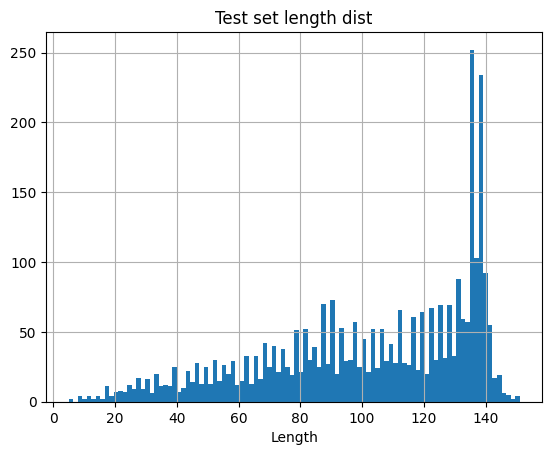

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [22]:
df_test["length"].hist(bins=100)
plt.xlabel("Length")
plt.title("Test set length dist")
plt.show()
print("Test Length Stat")
print(df_test["length"].describe())

<span style="font-size:1.1em;"> We see the two sets have a similar distribution which is heavy around 140 charcters and trails off into shorter lengths.

<span style="font-size:1.1em;">Lets split the training data into a trainign and validation set </span>


In [23]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=35)

X_test = df_test["text"]

## Model Architecture


<span style="font-size:1.1em;">I have chosen to use the BERT model architecture. This model is based on transformer encoders and is well suited for NLP tasks such as sentiment classification which is similar to the task we have here. One advantage is that we have available pre-trained model which we can fine tune with our data allowing us to use a more powerfull and large model with our relatively small computational resource.</span>

<span style="font-size:1.1em;">The image below shows a rough diagram of the BERT model architecture  </span>

![alt text](https://github.com/yepe4401/NLP_disaster_tweets/blob/main/BERT.jpeg?raw=1)

 <span style="font-size:1.1em;">In the input processing layer the input sequence is first broken up into tokens. The tokens are then geven token embeddings which are continuous vectors of length 768. The first token embedding is special and called [CLS] token. This token is what will be finally used for classification. The input layers also generate segmenta and position embeddings which help with longer text sequences to identify the location of sentences within a larger text. This is probably less important for our tweet classifcation task.

 <span style="font-size:1.1em;"> The embedding vectors are then propagated through a seires of transformer encoders. Each transformer encoder layer uses Multi-head self attention which allows it to consider all the tokens in the sequence at the same time. Feedforward and residual connections are provided to stabilize training and avoid exploding gradients or vanshing gradients. </span>

 <span style="font-size:1.1em;"> As the vectors propagate from one encoder layer to the next increasingly complex information can be extracted from them. At the outpout layer the [CLS] token which has been updated at each layer can be used in a fully connected layer of size 768 x (number of classes to classify the output. In our case thats 1536 + 2 bias parameters. The code for loading and trainign the BERT model is shown below. We are using the DistilledBERT which is slightly lighter model that maintains most ofthe same perforamnce</span>


In [24]:

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=120,
                                                                   name="custom_preprocessor"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics= ["accuracy"]
    )


# Fit
history = classifier.fit(x=df_train["text"],
                         y=df_train["target"],
                         batch_size=64,
                         epochs=2,
                         validation_data=(X_val, y_val)
                        )


100%|██████████| 580/580 [00:00<00:00, 406kB/s]
100%|██████████| 226k/226k [00:00<00:00, 910kB/s]
100%|██████████| 515/515 [00:00<00:00, 516kB/s]
100%|██████████| 253M/253M [00:07<00:00, 34.4MB/s]


Preprocessor: "custom_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.5983 - loss: 0.7013 - val_accuracy: 0.5653 - val_loss: 0.6850
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 96s 805ms/step - accuracy: 0.5975 - loss: 0.6826 - val_accuracy: 0.5653 - val_loss: 0.6851


 <span style="font-size:1.1em;"> We see the performance is not that great. Lets try to increase the sequence length from 120 to 160.</span>

In [25]:

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="custom_preprocessor"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics= ["accuracy"]
    )


# Fit
history = classifier.fit(x=df_train["text"],
                         y=df_train["target"],
                         batch_size=64,
                         epochs=2,
                         validation_data=(X_val, y_val)
                        )



Preprocessor: "custom_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.5632 - loss: 0.7465 - val_accuracy: 0.5653 - val_loss: 0.6869
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 102s 857ms/step - accuracy: 0.5975 - loss: 0.6849 - val_accuracy: 0.5653 - val_loss: 0.6858


 <span style="font-size:1.1em;"> Thats better. Lets see if we can improve performance more by tuning the learning rate. A shorter learning rate may be better</span>

In [26]:

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="custom_preprocessor"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()


classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics= ["accuracy"]
    )


# Fit
history = classifier.fit(x=df_train["text"],
                         y=df_train["target"],
                         batch_size=64,
                         epochs=2,
                         validation_data=(X_val, y_val)
                        )


Preprocessor: "custom_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7055 - loss: 0.5794 - val_accuracy: 0.8582 - val_loss: 0.3536
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8444 - loss: 0.3803 - val_accuracy: 0.8726 - val_loss: 0.3742


 <span style="font-size:1.1em;"> This looks pretty good lets now predict on the test set</span>

In [27]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [28]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step


In [29]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.475942
std,3146.427221,0.499497
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [30]:
sample_submission.to_csv("submission.csv", index=False)

# Conclusion

 <span style="font-size:1.1em;">This problem was one similar to sentiment classification in NLP. Therefore using a pre-trained NLP using the transformer architecture was a good choice. We saw that limiting the pre-processing to focus on text length of 160 charatcers which is close to but not below the upp bound of the lengths of the tweets helped improve the accuracy. Also using a slower learning rate in the ADAM weight adaptation proved more beneficial than the deault.</span>